In [20]:
# ruff: noqa: E402 F401
import os
from pathlib import Path

iskaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE")

# If on kaggle, install packages
if iskaggle:
    os.system("pip install fastai")

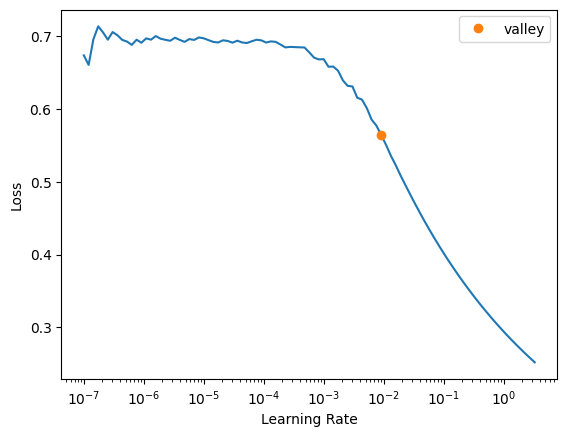

In [21]:
# https://forums.fast.ai/t/import-tensors-as-x-and-y-into-datablock/80356
import pandas as pd
import torch
import torch.nn as nn
from fastai.callback.schedule import fine_tune  # noqa: F811
from fastai.learner import Learner
from fastai.metrics import accuracy
from fastai.text.all import Categorize, Datasets, ItemTransform, L
from torch import Tensor, tensor
from transformers import BertModel, BertTokenizer

# https://huggingface.co/bert-base-uncased#how-to-use
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    cache_dir="tokenizers",
)
model = BertModel.from_pretrained(
    "bert-base-uncased",
    cache_dir="models",
)

example_data = {
    "text": [
        "This is a negative example.",
        "I love positive examples.",
        "Negative sentiment here.",
        "Positive vibes only.",
    ],
    "label": [
        "neg",
        "pos",
        "neg",
        "pos",
    ],
    "is_valid": [
        False,
        False,
        False,
        True,
    ],
}
df = pd.DataFrame(example_data)

# Extracting indices for training and validation sets
training_split = df[df["is_valid"] == False].index.tolist()  # noqa: E712
valid_split = df[df["is_valid"] == True].index.tolist()  # noqa: E712


class GetX(ItemTransform):
    @staticmethod
    def encode_text(text: str) -> Tensor:
        encoding = tokenizer(
            text,
            return_tensors="pt",
            # https://stackoverflow.com/questions/70067608/how-padding-in-huggingface-tokenizer-works
            padding="max_length",
            max_length=72,
            truncation=True,
        )

        # text_output.shape == [1, 768]
        text_output = model(**encoding).last_hidden_state.mean(dim=1)
        return text_output[0]

    def encodes(self, x) -> Tensor:
        # x: pd.DataFrame
        text_tensor: Tensor = GetX.encode_text(x["text"])
        # TODO use audio tensor from openSMILE
        # either read file or have tensor in pandas df
        audio_tensor: Tensor = Tensor([0])
        concat_tensor: Tensor = torch.cat((text_tensor, audio_tensor), dim=0)

        # print(concat_tensor.shape)
        # concat_tensor.shape == [769]
        return concat_tensor


class GetY(ItemTransform):
    def encodes(self, x) -> str:
        # x: pd.DataFrame
        return x["label"]


tls = Datasets(
    df,
    [
        (GetX,),
        # TODO Choose output for sentiment / emotion
        (GetY, Categorize),
    ],
    splits=[training_split, valid_split],
)

dls = tls.dataloaders(
    batch_size=1,
    num_workers=0,
    # https://docs.fast.ai/data.core.html
)
# print("--------------------------------")
# print(L(dls.train))


# TODO Use a fastai model?
class CustomModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        # TODO Should I use more layers?
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x: Tensor) -> Tensor:
        return self.fc(x)


input_size = 769  # Update this based on the shape of your input tensor
output_size = len(df["label"].unique())  # Update this based on the number of unique labels
custom_model = CustomModel(input_size, output_size)

# Create a Learner
learner = Learner(
    dls,
    custom_model,
    # TODO What other loss functions are there?
    loss_func=nn.CrossEntropyLoss(),
    metrics=[accuracy],  # Choose appropriate metrics
)

# Find a good learning rate
suggested_learn_rate = learner.lr_find().valley

In [22]:
epochs = 4

# Choose a learning rate based on the plot
# lr = 1e-2
lr = suggested_learn_rate
print(f"Chosen learn rate: {lr}")

# Fine-tune the model
learner.fine_tune(epochs, lr)

Chosen learn rate: 0.009120108559727669


epoch,train_loss,valid_loss,accuracy,time
0,0.723675,0.924926,0.000000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.489809,1.052476,0.000000,00:00
1,0.428394,1.232834,0.000000,00:00
2,0.358212,1.149088,0.000000,00:00
3,0.301743,1.147548,0.000000,00:00


In [24]:
# Show model structure
print(learner.model)

CustomModel(
  (fc): Linear(in_features=769, out_features=2, bias=True)
)


In [27]:
# Predict a text

# data = {"text": "I love positive examples."}
# series = pd.Series(data)
# learner.predict(series)

text_encoded = GetX.encode_text("I love positive examples.")
concat_tensor = torch.cat(
    (
        text_encoded,
        tensor([0]).float(),
    )
)
label, clas, probs = learner.predict(concat_tensor)
print(label)
print(clas)
print(probs)

/home/burny/.cache/pypoetry/virtualenvs/deep-learning-examples-d9n-7CCf-py3.11/lib/python3.11/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


['neg', 'neg']
tensor([-0.9980,  0.7915])
tensor([-0.9980,  0.7915])
